# decision tree

## imports, data

In [33]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [34]:
import copy

In [35]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

In [36]:
df = pd.read_csv('df')

In [37]:
df.index.name=None
df.reset_index(inplace=True)

In [38]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [39]:
df.head()

,ind,dates,sales,AUP_RUR,AUP_RUR_RRP,AUP+bonus
2012-09-09,1,2012-09-09,23,5658.513739,9619.448357,6612.109391
2012-09-16,2,2012-09-16,10,6065.175200,10238.858811,6762.978200
2012-09-23,3,2012-09-23,9,5876.925926,9058.186700,6231.744815
2012-09-30,4,2012-09-30,4,5319.947500,9415.000000,6163.250000
2012-10-07,5,2012-10-07,4,6731.930000,9415.000000,6807.750000


In [40]:
data2 = copy.deepcopy(df[['dates','sales']])

## features addition

In [41]:
data2.dates = pd.to_datetime(data2.dates)
data2.TRDATETIME = pd.to_datetime(data2['dates'],  dayfirst= True, format='%d%b%y:%H:%M:%S')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [42]:
data2['date'] = data2['dates'].dt.date
data2['day'] = data2['dates'].dt.day
data2['month'] = data2['dates'].dt.month
data2['year'] = data2['dates'].dt.year

In [43]:
data2.head()

,dates,sales,date,day,month,year
2012-09-09,2012-09-09,23,2012-09-09,9,9,2012
2012-09-16,2012-09-16,10,2012-09-16,16,9,2012
2012-09-23,2012-09-23,9,2012-09-23,23,9,2012
2012-09-30,2012-09-30,4,2012-09-30,30,9,2012
2012-10-07,2012-10-07,4,2012-10-07,7,10,2012


In [44]:
data2['season'] = data2.sales

In [45]:
data2['season'].loc['2012':'2013-03-01'] = "aw"
data2['season'].loc['2013-03-01':'2013-09-01'] = "ss"
data2['season'].loc['2013-09-01':'2014-03-01'] = "aw"
data2['season'].loc['2014-03-01':'2014-09-01'] = "ss"
data2['season'].loc['2014-09-01':'2015-03-01'] = "aw"
data2['season'].loc['2015-03-01':'2015-09-01'] = "ss"
data2['season'].loc['2015-09-01':'2016-03-01'] = "aw"
data2['season'].loc['2016-03-01':'2016-09-01'] = "ss"
data2['season'].loc['2016-09-01':'2017-03-01'] = "aw"
data2['season'].loc['2017-03-01':'2017-09-01'] = "ss"
data2['season'].loc['2017-09-01':'2018-03-01'] = "aw"
data2['season'].loc['2018-03-01':'2018-09-01'] = "ss"

C:\Pythonn\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
data2['Last_Week_Sales'] = data2['sales'].shift()
data2['Last_Week_Diff'] = data2['Last_Week_Sales'].diff()
data2 = data2.dropna()

In [47]:
data2.head()

,dates,sales,date,day,month,year,season,Last_Week_Sales,Last_Week_Diff
2012-09-23,2012-09-23,9,2012-09-23,23,9,2012,aw,10.0,-13.0
2012-09-30,2012-09-30,4,2012-09-30,30,9,2012,aw,9.0,-1.0
2012-10-07,2012-10-07,4,2012-10-07,7,10,2012,aw,4.0,-5.0
2012-10-14,2012-10-14,6,2012-10-14,14,10,2012,aw,4.0,0.0
2012-10-21,2012-10-21,2,2012-10-21,21,10,2012,aw,6.0,2.0


In [48]:
data2['weeks'] = list(range(len(data2.index)))

In [49]:
data2.index = list(range(len(data2.index)))

In [50]:
data2.drop('dates', axis = 1, inplace = True)

In [51]:
data2.drop('date', axis = 1, inplace = True)

In [52]:
data2.head()

,sales,day,month,year,season,Last_Week_Sales,Last_Week_Diff,weeks
0,9,23,9,2012,aw,10.0,-13.0,0
1,4,30,9,2012,aw,9.0,-1.0,1
2,4,7,10,2012,aw,4.0,-5.0,2
3,6,14,10,2012,aw,4.0,0.0,3
4,2,21,10,2012,aw,6.0,2.0,4


In [53]:
data3 = pd.get_dummies(data2)

In [54]:
data3.head()

,sales,day,month,year,Last_Week_Sales,Last_Week_Diff,weeks,season_aw,season_ss
0,9,23,9,2012,10.0,-13.0,0,1,0
1,4,30,9,2012,9.0,-1.0,1,1,0
2,4,7,10,2012,4.0,-5.0,2,1,0
3,6,14,10,2012,4.0,0.0,3,1,0
4,2,21,10,2012,6.0,2.0,4,1,0


In [55]:
Y = data3.sales

In [56]:
X = data3.drop('sales', axis = 1)

## функция ошибки, baseline

нужно использовать MAE, RMSE, MSE, R2

In [273]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from math import sqrt

def rmse(ytrue,ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred));
def mse(ytrue,ypred):
    return (mean_squared_error(ytrue, ypred));
def rmsle(ytrue, ypred):
    return mean_squared_log_error(ytrue, ypred);
def mae (ytrue,ypred):
    return mean_absolute_error(ytrue,ypred);
def r2 (ytrue,ypred):
    return r2_score(ytrue,ypred);
def evs (ytrue,ypred):
    return explained_variance_score(ytrue,ypred);
def medae (ytrue,ypred):
    return median_absolute_error(ytrue,ypred)

In [274]:
mean_error = []
for week in range(300,307):
    train = data3[data3['weeks'] < week]
    val = data3[data3['weeks'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = mae(val['sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 300 - Error 148.00000
Week 301 - Error 136.00000
Week 302 - Error 117.00000
Week 303 - Error 5.00000
Week 304 - Error 127.00000
Week 305 - Error 41.00000
Week 306 - Error 229.00000
Mean Error = 114.71429


???? т.к. предыдущий подход с деревьями оказался нерабочим, переделал модель через кросс-валидацию???

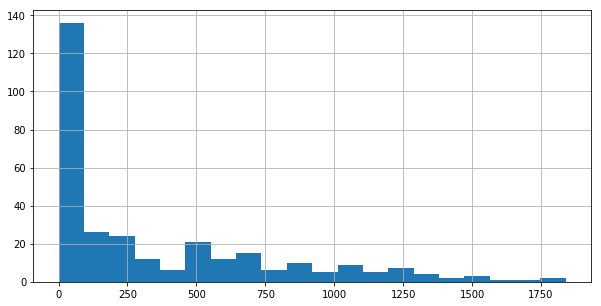

In [275]:
data3['sales'].hist(bins=20, figsize=(10,5))

## X_train, Y_train, X_test, Y_test

In [276]:
X_test = data3[302:].drop('sales', axis = 1)

In [277]:
Y_test = data3[302:].sales

In [278]:
X_train = data3[:302].drop('sales', axis = 1)
Y_train = data3[:302].sales

## CV function

In [279]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)
   
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) 

        index = int(np.floor(X.shape[0] * split))
        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)
   
    return errors.mean()

???? по всем  моделям с индексом 1.5 пока еще не сделано финальное предсказание???? 

### RFR

In [260]:
mdl = RandomForestRegressor(n_estimators=100, criterion='mae',n_jobs=-1)

In [280]:
performTimeSeriesCV(X_train, Y_train, 10, mdl, mae)

Size train set: (302, 8)
Size of each fold: 30

Splitting the first 2 chunks at 1/2
Size of train + test: (60, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (90, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (120, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (150, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (180, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (210, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (240, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (270, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (300, 8)


130.33157088122607

### XGBR

In [262]:
from xgboost import XGBRegressor

In [263]:
mdl1 = XGBRegressor(learning_rate=0.1, n_estimators=1000, booster='gblinear' )

In [281]:
performTimeSeriesCV(X_train, Y_train, 10, mdl1, mae)

Size train set: (302, 8)
Size of each fold: 30

Splitting the first 2 chunks at 1/2
Size of train + test: (60, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (90, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (120, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (150, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (180, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (210, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (240, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (270, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (300, 8)


102.63172607860345

### LinReg

In [265]:
import sklearn.linear_model as lm

In [266]:
mdl2 = lm.LinearRegression(normalize=False)

In [285]:
performTimeSeriesCV(X_train, Y_train, 150, mdl2, mae)

Size train set: (302, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

Size of train + test: (278, 8)

Splitting the first 140 chunks at 139/140
Size of train + test: (280, 8)

Splitting the first 141 chunks at 140/141
Size of train + test: (282, 8)

Splitting the first 142 chunks at 141/142
Size of train + test: (284, 8)

Splitting the first 143 chunks at 142/143
Size of train + test: (286, 8)

Splitting the first 144 chunks at 143/144
Size of train + test: (288, 8)

Splitting the first 145 chunks at 144/145
Size of train + test: (290, 8)

Splitting the first 146 chunks at 145/146
Size of train + test: (292, 8)

Splitting the first 147 chunks at 146/147
Size of train + test: (294, 8)

Splitting the first 148 chunks at 147/148
Size of train + test: (296, 8)

Splitting the first 149 chunks at 148/149
Size of train + test: (298, 8)

Splitting the first 150 chunks at 149/150
Size of train + test: (300, 8)


92.55410893276067

## XGB по-другому, показал чуть более худший результат, чем в другой функции кроссвалидации. с этим пока не разобрался

In [298]:
import xgboost as xgb

def XGB_forecast(X_train, Y_train, X_test, Y_test):

    # исходные данные
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gbtree'
    }
    trees = 100

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=2, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    cv.plot(y=['test-rmse-mean', 'train-rmse-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(Y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)



    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(list(Y_test), label="y_test")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Root Mean square error {} bks".format(round(rmse(prediction_test, Y_test))))
    plt.grid(True)
    plt.legend()

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
C:\Pythonn\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


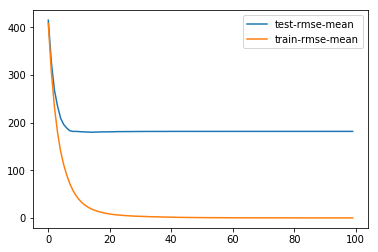

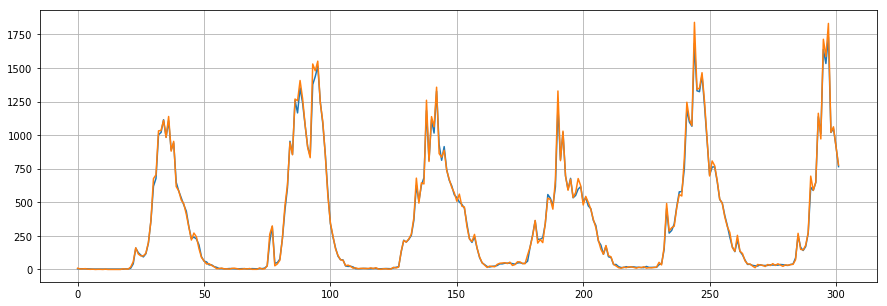

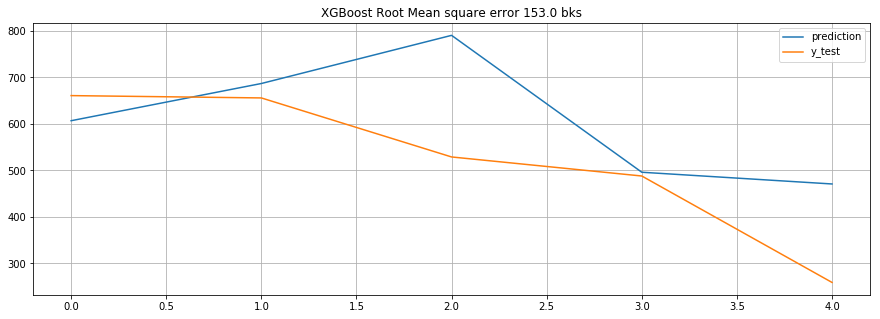

In [299]:
XGB_forecast(X_train, Y_train, X_test, Y_test)

## Выводы по моделям

1.  в целом, на кросс-валидации все модели (включая keras из другого файла) показали себя существенно лучше.
2. лучше всего на кроссвалидации выступила обычная линейная регрессия
3. модели еще не проходили полноценный "тюнинг", проверил несколько параметров по наитию
4. пока еще не сделаны финальные предсказания, но результат, в целом, неплохой
5. продублирую вопрос из файла с keras - есть проблема с выбором метрики ошибки, тут нужна помощь